<a href="https://colab.research.google.com/github/rubyvanrooyen/astrokat/blob/colab_helper_interface/notebooks/astrokat_fitflux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AstroKAT flux fit
Scale flux model coefficients from GHz to MHz for MeerKAT telescope

Reference: Perley & Butler 2017

In [ ]:
import numpy
import matplotlib.pyplot as plt

## Perley & Butler 2017

In [ ]:
# Listed frequencies used for fitting
fit_frequencies_mhz = numpy.array([73.8, 232, 247, 275, 296, 312, 328, 344,
                                   357, 382, 392, 403, 422, 437, 457, 471,
                                   1040, 1488, 1808, 2052, 2948, 4764, 6564,
                                   8592, 11064, 14192, 16564, 19064, 25564,
                                   32064, 37064, 42064, 48064])  # MHz

In [ ]:
# Listed coefficients in GHz as per reference
# name : Flux model (Min freq [MHz] Max freq [MHz] [model coefficients, GHz])
flux_cals = {"J0437+2940":
             numpy.array([50., 50000., 1.8017, -0.7884, -0.1035, -0.0248]),
             "J0519-4546":
             numpy.array([200., 4000., 1.9380, -0.7470, -0.074]),
             "J0534+2200":
             numpy.array([50., 4000., 2.9516, -0.217, -0.047, -0.067]),
             "J0918-1205":
             numpy.array([50., 12000., 1.7795, -0.9176, -0.084, -0.0139]),
             "J1230+1223":
             numpy.array([50., 3000., 2.4466, -0.8116, -0.048]),
             "J1331+3030":
             numpy.array([50., 50000., 1.2481, -0.4507, -0.1798, 0.0357]),
             "J1651+0459":
             numpy.array([200., 12000., 1.8298, -1.0247, -0.0951]),
             "J1720-0058":
             numpy.array([200., 4000., 1.8627, -0.6938, -0.1, -0.032]),
             "J0137+3309":
             numpy.array([50., 50000., 1.3253, -0.7553, -0.1914, 0.0498]),
             "J0521+1638":
             numpy.array([200., 50000., 1.0088, -0.4981, -0.155, -0.0100]),
             }

## Library functions

In [ ]:
def find_nearest(array, value):
    """Find index and nearest value in array."""
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return idx, array[idx]

In [ ]:
def calc_flux_density(coeffs, freqs):
    """Calculate flux density from polynomial equation."""
    log10S = [coeffs[0]] * len(freqs)
    for idx, coeff in enumerate(coeffs[1:]):
        log10S += coeff * (numpy.log10(freqs)**(idx + 1))
    return log10S

In [ ]:
# Scale the polynomial coefficients using a numpy refit
def coeffs_ghz2mhz(coeffs, min_freq_mhz=50, max_freq_mhz=50000, verbose=False):
    """Scaling the flux model coefficients from the GHz used to MHz."""
    [min_idx, value] = find_nearest(fit_frequencies_mhz, min_freq_mhz)
    [max_idx, value] = find_nearest(fit_frequencies_mhz, max_freq_mhz)
    fit_freq_mhz = fit_frequencies_mhz[min_idx:max_idx]
    fit_freq_ghz = fit_freq_mhz / 1e3

    log10S = calc_flux_density(coeffs, fit_freq_ghz)

    # Polynomial fit to obtain coefficients for frequencies in MHz
    deg = len(coeffs) - 1
    x = numpy.log10(fit_freq_mhz)
    y = log10S
    coeffs_ = numpy.polyfit(x, y, deg)[::-1]
    log10S_ = calc_flux_density(coeffs_, 10.**x)

    plt.figure(figsize=(17, 5), facecolor="white")
    plt.subplot(121)
    plt.loglog(fit_freq_ghz, 10.**log10S)
    plt.title(calib)
    plt.ylabel("Flux Density [Jy]")
    plt.xlabel("Frequency(GHz)")
    plt.axis("tight")
    plt.subplot(122)
    plt.loglog(10.**x, 10.**y, "b", 10.**x, 10.**log10S_, "r--")
    plt.ylabel("Flux Density [Jy]")
    plt.xlabel("Frequency(MHz)")
    plt.axis("tight")

    return coeffs_

## MeerKAT  coefficient calculation
Scaling the flux model coefficients from the GHz used to MHz:
* scale coefficients using simple math:    
`refit = False`
* scale coefficients by refitting the polynomial:    
`refit = True` (default)

J0437+2940 [ 3.905  -0.837   0.1197 -0.0248]
J0519-4546 [ 3.513 -0.303 -0.074]
J0534+2200 [ 4.9886 -1.744   0.556  -0.067 ]
J0918-1205 [ 4.1516 -0.7889  0.0411 -0.0139]
J1230+1223 [ 4.4494 -0.5236 -0.048 ]
J1331+3030 [ 0.0181  1.592  -0.5011  0.0357]
J1651+0459 [ 4.048  -0.4541 -0.0951]
J1720-0058 [ 3.9081 -0.9578  0.188  -0.032 ]
J0137+3309 [ 0.524   1.7377 -0.6396  0.0498]
J0521+1638 [ 1.3781  0.1619 -0.065  -0.01  ]


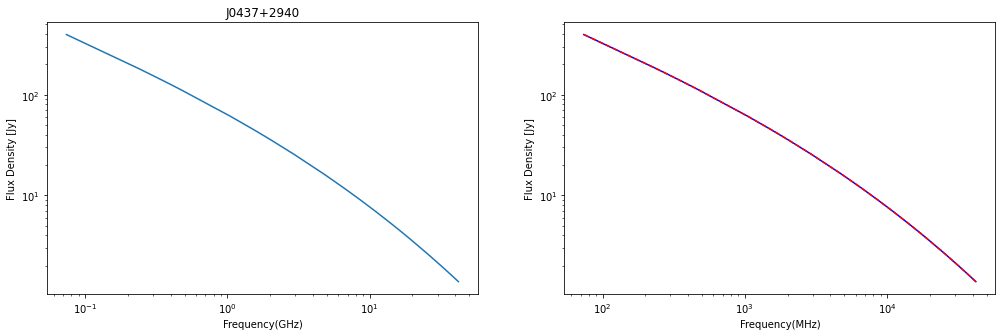

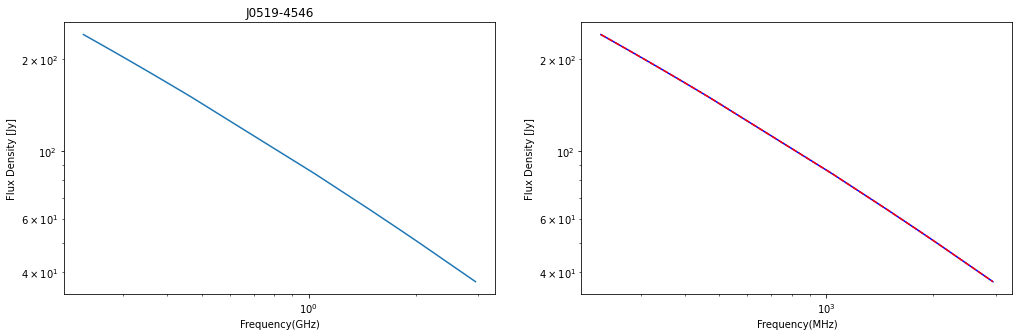

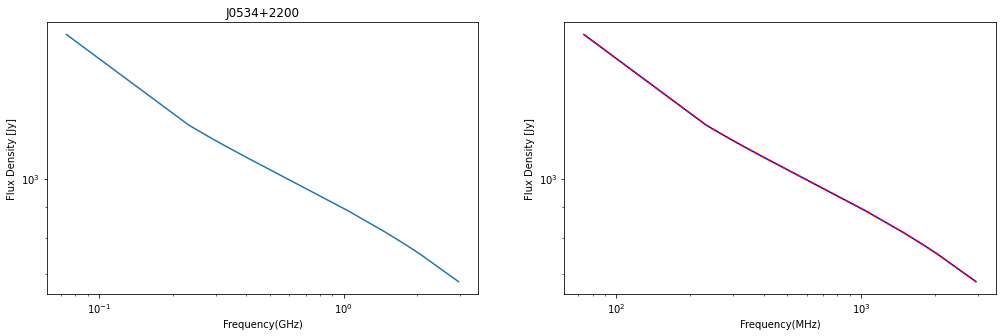

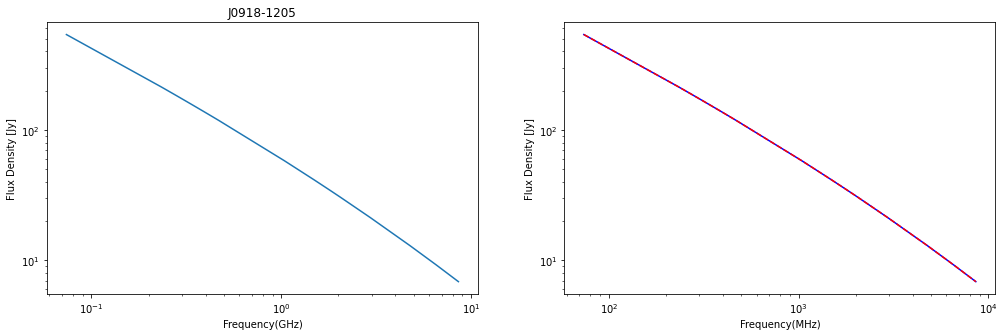

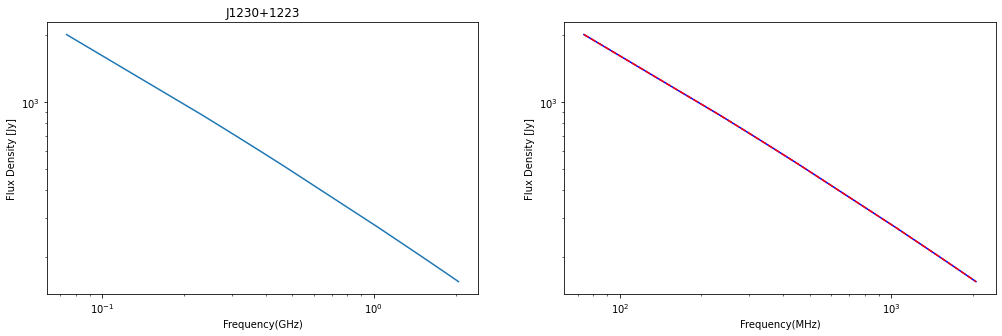

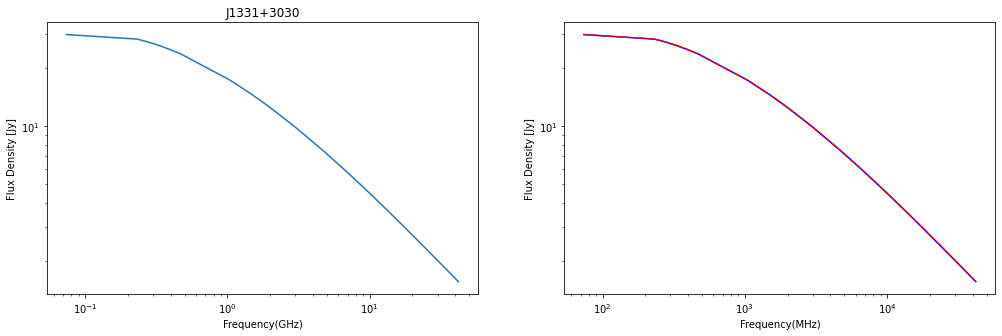

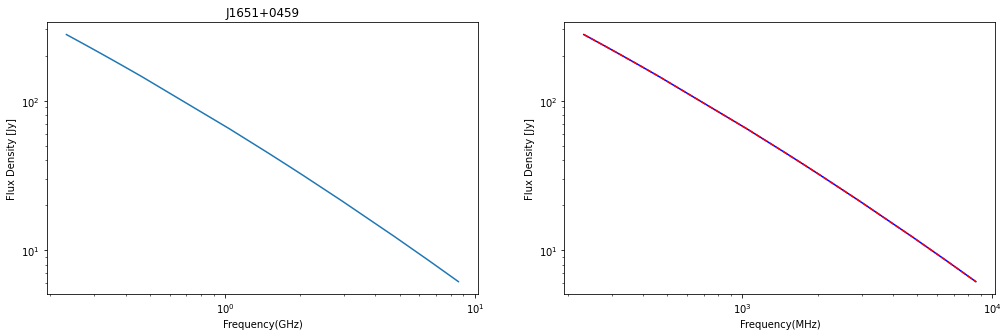

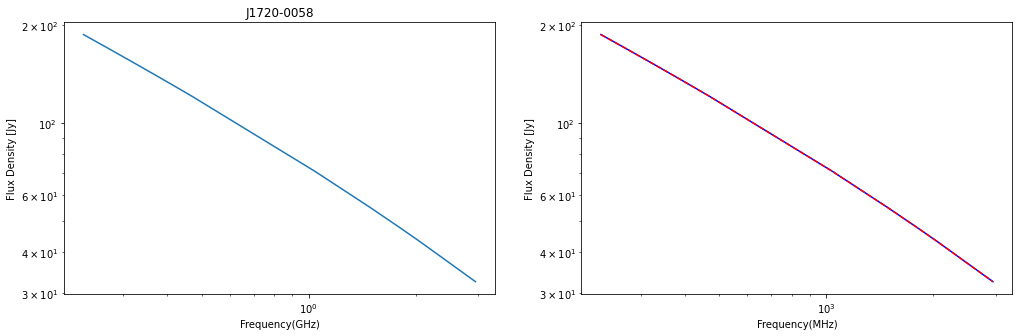

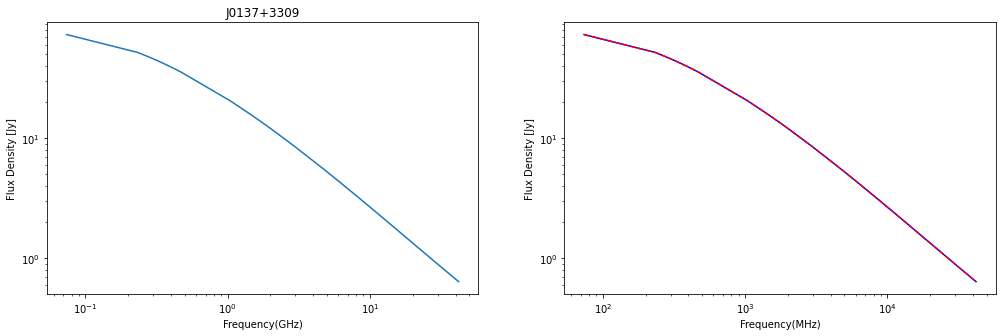

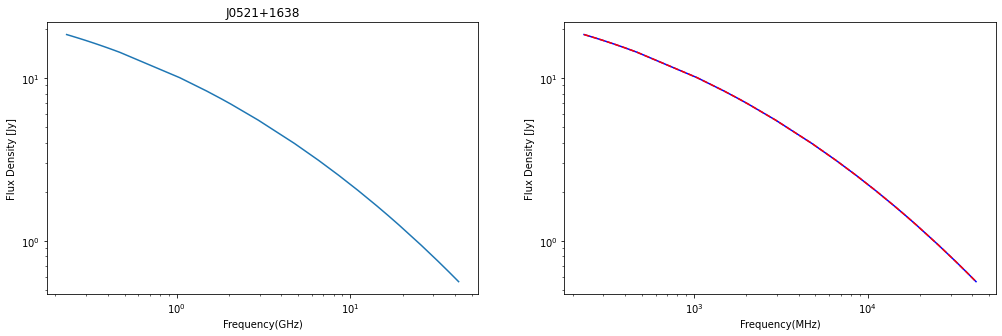

In [ ]:
refit = True
for calib in flux_cals.keys():
    # Flux density of calibrator over frequency using fitted coefficients
    min_freq_mhz = flux_cals[calib][0]
    max_freq_mhz = flux_cals[calib][1]
    coeffs = flux_cals[calib][2:]
    if refit:
        coeffs_ = coeffs_ghz2mhz(coeffs,
                                 min_freq_mhz=min_freq_mhz,
                                 max_freq_mhz=max_freq_mhz)
    else:
        [A, B] = coeffs[:2]
        C = 0
        if len(coeffs) > 2:
            C = coeffs[2]
        D = 0
        if len(coeffs) > 3:
            D = coeffs[3]
        a = A - 3. * B + 9. * C - 27. * D
        b = B - 6. * C + 27. * D
        c = C - 9. * D
        d = D
        coeffs_ = numpy.array([a, b, c, d])
    print(calib, coeffs_)